In [1]:
import pandas as pd
import numpy as np
from numpy import array
from numpy import mean
from numpy import std
from tensorflow import keras
from keras.models import Sequential
from tensorflow.keras.layers import LSTM
from keras.layers import Dense
import matplotlib.pyplot as plt
from keras.layers import TimeDistributed
from sklearn.preprocessing import MinMaxScaler

In [2]:
# split a univariate sequence into samples
def split_sequence(sequence, n_steps_in, n_steps_out, step_interval):
    X, y = list(), list()
    example_count = int((len(sequence)/step_interval))
    for i in range(example_count):
        # find the end of this pattern
        end_ix = (i*step_interval) + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the sequence
        if out_end_ix > len(sequence):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[(i*step_interval):end_ix], sequence[end_ix:out_end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

Load data, datetime to index, downsample with left edge label, convert wei to gwei

In [3]:
def training_split_limited():
    #Load data as float, datetime to index
    data = pd.read_csv (r'C:\Users\conal\Desktop\MCM\Practicum\data\min,max,average gas 11-26 to 01-26 QUERY 2.csv', header=0)
    data['block_timestamp'] = pd.to_datetime(data['block_timestamp'], format = '%Y-%m-%d %H:%M:%S UTC')
    data = data.set_index('block_timestamp')
    data = data.squeeze()
    data = data.astype('float')

    #Resample with left edge label i.e min 1-5 mean labelled as min1
    data = data.resample(resample_rate).mean()
    
    #Add 24hr lag for min gas price
    data['min_gas_price_24hr lag'] = data['min_gas_price'].shift(288)
    data = data[288:]

    #Convert to gwei
    data = data.apply(lambda x: x/1000000000)
    data =data[inputs]

    #Filter inputs, set outlier limit
    data =data[inputs]
    data_mean, data_std = mean(data["min_gas_price"]), std(data["min_gas_price"])
    cut_off = data_std * 2
    lower, upper = data_mean - cut_off, data_mean + cut_off
    for index,row in data.iterrows():
      if row["min_gas_price"] < lower:
        row["min_gas_price"]=lower
      elif row["min_gas_price"] > upper:
        row["min_gas_price"]=upper

    #Filter inputs, set outlier limit
    data =data[inputs]
    scaler = MinMaxScaler()
    data[inputs] = scaler.fit_transform(data[inputs])





    #Creat input:output examples
    data = data[start_date:end_date].to_numpy()
    X, y = split_sequence(data, n_steps_in, n_steps_out, step_interval)
    X_train, X_val = np.split(X, [int(0.7 * len(X))])
    y_train, y_val = y_train, y_val = np.split(y, [int(0.7 * len(X))])

    #Reshape to 3D for LSTM
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], len(inputs)))
    y_train =y_train.reshape((y_train.shape[0], y_train.shape[1], len(inputs)))
    X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], len(inputs)))
    y_val = y_val.reshape((y_val.shape[0], y_val.shape[1], len(inputs)))
    y_train =y_train[ :, :, :1]
    y_val =y_val[ :, :, :1]
    return X_train, y_train, X_val, y_val, scaler



In [4]:
def training_split_no_limits():    
    #Load data as float, datetime to index
    data = pd.read_csv (r'C:\Users\conal\Desktop\MCM\Practicum\data\min,max,average gas 11-26 to 01-26 QUERY 2.csv', header=0)
    data['block_timestamp'] = pd.to_datetime(data['block_timestamp'], format = '%Y-%m-%d %H:%M:%S UTC')
    data = data.set_index('block_timestamp')
    data = data.squeeze()
    data = data.astype('float')

    #Resample with left edge label i.e min 1-5 mean labelled as min1
    data = data.resample(resample_rate).mean()
    
    #Add 24hr lag for min gas price
    data['min_gas_price_24hr lag'] = data['min_gas_price'].shift(288)
    data = data[288:]

    #Convert to gwei
    data = data.apply(lambda x: x/1000000000)
    data =data[inputs]

    #Filter inputs, set outlier limit
    data =data[inputs]
    scaler = MinMaxScaler()
    data[inputs] = scaler.fit_transform(data[inputs])


    #Creat input:output examples
    data = data[start_date:end_date].to_numpy()
    X, y = split_sequence(data, n_steps_in, n_steps_out, step_interval)
    X_train2, X_val2 = np.split(X, [int(0.7 * len(X))])
    y_train2, y_val2 = y_train, y_val = np.split(y, [int(0.7 * len(X))])

    #Reshape to 3D for LSTM
    X_train = X_train2.reshape((X_train2.shape[0], X_train2.shape[1], len(inputs)))
    y_train =y_train2.reshape((y_train2.shape[0], y_train2.shape[1], len(inputs)))
    X_val2 = X_val2.reshape((X_val2.shape[0], X_val2.shape[1], len(inputs)))
    y_val2 = y_val2.reshape((y_val2.shape[0], y_val2.shape[1], len(inputs)))
    y_train2 =y_train2[ :, :, :1]
    y_val2 =y_val2[ :, :, :1]
    return X_train2, y_train2, X_val2, y_val2, scaler2

In [5]:
resample_rate = '5T'
start_date='2021-11-26 00:00:00'
end_date='2021-12-26 23:55:00' 
inputs = ['min_gas_price', 'max_gas_price']
#No of timesteps behind to forecast on, no of timesteps to forecast ahead
n_steps_in = 2016
n_steps_out = 1
#How many timesteps between start of training examples
step_interval = 1

In [6]:
X_train, y_train, X_val, y_val, scaler = training_split_limited()

In [7]:
X_train2, y_train2, X_val2, y_val2, scaler2 = training_split_no_limits()

NameError: name 'scaler2' is not defined

In [104]:
# define model
model = Sequential()
model.add(LSTM(units =15,activation='tanh',input_shape=(n_steps_in, len(inputs)),dropout=0.01))
model.add(Dense(n_steps_out))
opt = keras.optimizers.Adam(learning_rate=0.01, decay=0.0001)
model.compile(optimizer='adam', loss='mse')

In [ ]:
model.fit(X_train, y_train, epochs=15, verbose=1, validation_data = (X_val, y_val))

Epoch 1/15
152/152 [==============================] - 11s 58ms/step - loss: 0.0113 - val_loss: 0.0048
Epoch 2/15
152/152 [==============================] - 8s 54ms/step - loss: 0.0087 - val_loss: 0.0044
Epoch 3/15
152/152 [==============================] - 8s 54ms/step - loss: 0.0080 - val_loss: 0.0041
Epoch 4/15
152/152 [==============================] - 8s 54ms/step - loss: 0.0073 - val_loss: 0.0038
Epoch 5/15
152/152 [==============================] - 8s 54ms/step - loss: 0.0066 - val_loss: 0.0040
Epoch 6/15
152/152 [==============================] - 8s 52ms/step - loss: 0.0063 - val_loss: 0.0037
Epoch 7/15
152/152 [==============================] - 8s 53ms/step - loss: 0.0060 - val_loss: 0.0034
Epoch 8/15
152/152 [==============================] - 8s 54ms/step - loss: 0.0063 - val_loss: 0.0033
Epoch 9/15
152/152 [==============================] - 8s 54ms/step - loss: 0.0059 - val_loss: 0.0033
Epoch 10/15
152/152 [==============================] - 8s 54ms/step - loss: 0.0059 - val_l

Trainign stopped early as model stopped learning

In [98]:
yhat = model.predict(X_val, verbose=1)

65/65 [==============================] - 2s 23ms/step


RMSE 12.83401084050738
MAE 7.43731224473069
MAPE 0.1040612922445297
R^2 0.720811580725423


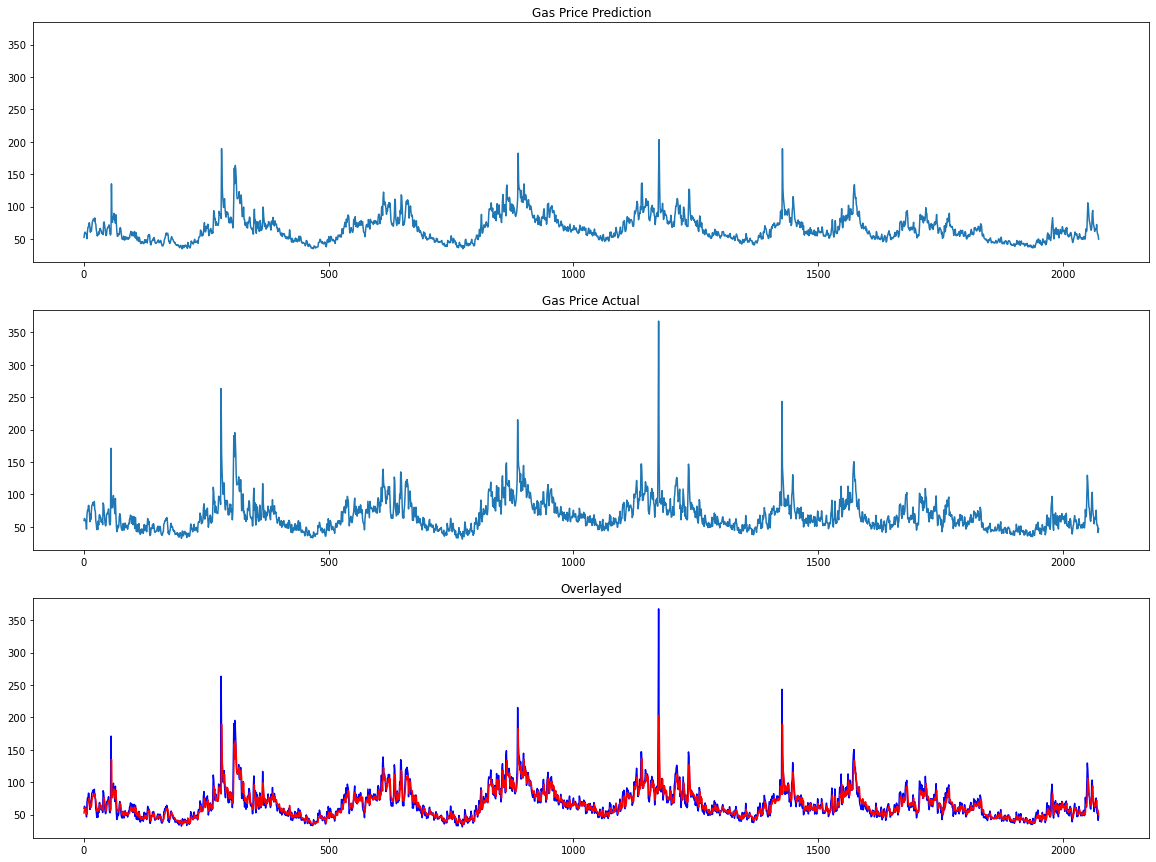

In [110]:
#Minmax scaler has been fit with 2d data, 
pred_descaled= (scaler.inverse_transform(array([yhat,]*len(inputs)).transpose()[0]))[:, :1]
groud_truth_descaled= (scaler2.inverse_transform(array([y_val2,]*len(inputs)).transpose()[0][0]))[ :, :1]


f, (ax1, ax2, ax3) = plt.subplots(3, 1, sharey=True)
f.set_figwidth(20)
f.set_figheight(15)
ax1.plot(pred_descaled)
ax1.title.set_text('Gas Price Prediction')
ax2.plot(groud_truth_descaled)
ax2.title.set_text('Gas Price Actual')


ax3.title.set_text('Overlayed')
ax3.plot(groud_truth_descaled, color='blue',label='Predicted '+' Gas Price')
ax3.plot(pred_descaled, color='red',label='real '+' Gas Price')



print('RMSE ' + str(mean_squared_error(groud_truth_descaled, pred_descaled, squared=False)))
print('MAE ' + str(mean_absolute_error(groud_truth_descaled, pred_descaled)))
print('MAPE ' + str(mean_absolute_percentage_error(groud_truth_descaled, pred_descaled)))
print('R^2 ' + str(r2_score(groud_truth_descaled, pred_descaled)))

## Lets try without limiting outliers


In [16]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler


In [114]:
# define model
model = Sequential()
model.add(LSTM(units =15,activation='tanh',input_shape=(n_steps_in, len(inputs)),dropout=0.01))
model.add(Dense(n_steps_out))
opt = keras.optimizers.Adam(learning_rate=0.01, decay=0.0001)
model.compile(optimizer='adam', loss='mse')

In [115]:
model.fit(X_train2, y_train2, epochs=25, verbose=1, validation_data=(X_val2, y_val2))

Epoch 1/25
152/152 [==============================] - 11s 58ms/step - loss: 0.0010 - val_loss: 1.5364e-04
Epoch 2/25
152/152 [==============================] - 8s 53ms/step - loss: 7.4244e-04 - val_loss: 1.2939e-04
Epoch 3/25
152/152 [==============================] - 8s 53ms/step - loss: 6.7959e-04 - val_loss: 1.3999e-04
Epoch 4/25
152/152 [==============================] - 8s 54ms/step - loss: 6.4196e-04 - val_loss: 1.1574e-04
Epoch 5/25
152/152 [==============================] - 8s 54ms/step - loss: 6.2054e-04 - val_loss: 1.0872e-04
Epoch 6/25
152/152 [==============================] - 8s 53ms/step - loss: 5.9711e-04 - val_loss: 1.4780e-04
Epoch 7/25
152/152 [==============================] - 8s 54ms/step - loss: 5.7786e-04 - val_loss: 1.1684e-04
Epoch 8/25
152/152 [==============================] - 8s 54ms/step - loss: 5.6027e-04 - val_loss: 1.0049e-04
Epoch 9/25
152/152 [==============================] - 8s 55ms/step - loss: 5.6209e-04 - val_loss: 9.8292e-05
Epoch 10/25
152/152 [=

In [116]:
yhat = model.predict(X_val2, verbose=1)

65/65 [==============================] - 2s 19ms/step


Looks like we are getting a uniform prediction with a simple model on multivariate data

RMSE 15.195524748010257
MAE 10.745217632741147
MAPE 0.17392558548663856
R^2 0.6086151590664763


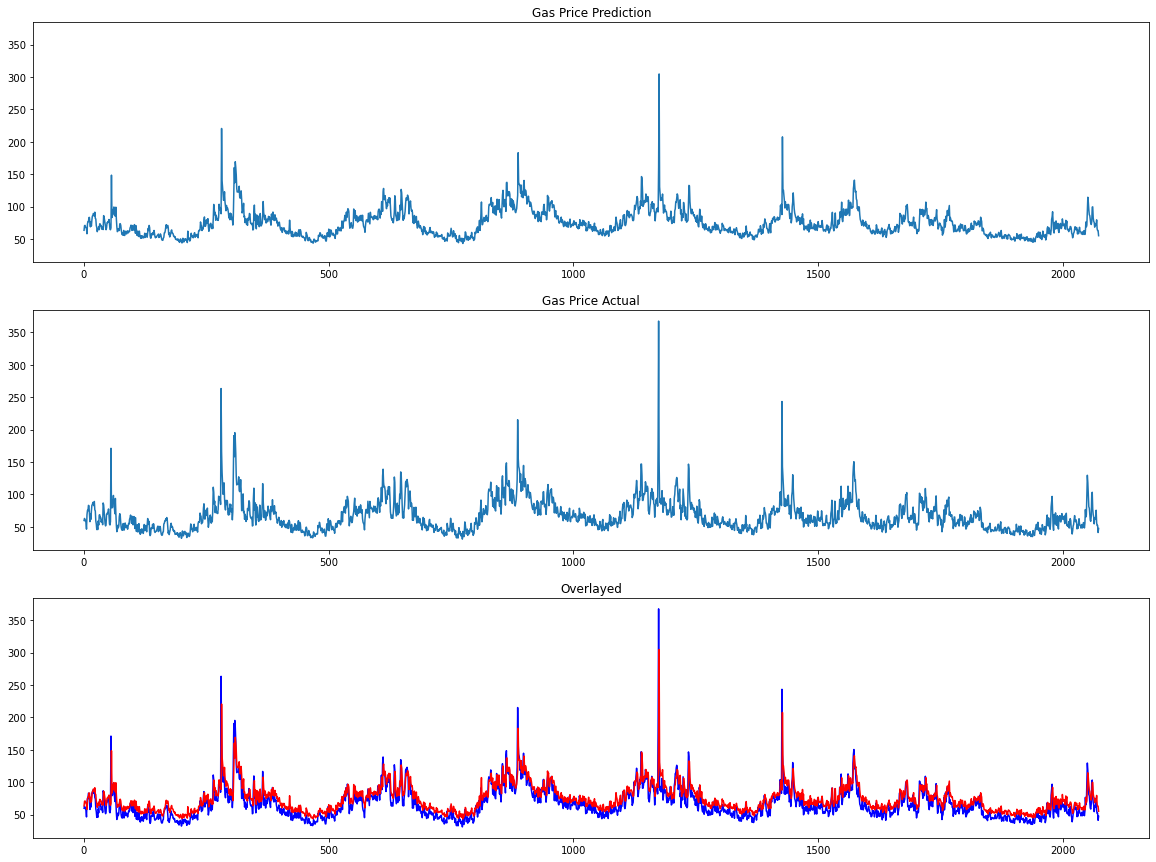

In [118]:
#Minmax scaler has been fit with 2d data, 
pred_descaled= (scaler2.inverse_transform(array([yhat,]*2).transpose()[0]))[:, :1]
groud_truth_descaled= (scaler2.inverse_transform(array([y_val2,]*2).transpose()[0][0]))[ :, :1]


f, (ax1, ax2, ax3) = plt.subplots(3, 1, sharey=True)
f.set_figwidth(20)
f.set_figheight(15)
ax1.plot(pred_descaled)
ax1.title.set_text('Gas Price Prediction')
ax2.plot(groud_truth_descaled)
ax2.title.set_text('Gas Price Actual')


ax3.title.set_text('Overlayed')
ax3.plot(groud_truth_descaled, color='blue',label='Predicted '+' Gas Price')
ax3.plot(pred_descaled, color='red',label='real '+' Gas Price')



print('RMSE ' + str(mean_squared_error(groud_truth_descaled, pred_descaled, squared=False)))
print('MAE ' + str(mean_absolute_error(groud_truth_descaled, pred_descaled)))
print('MAPE ' + str(mean_absolute_percentage_error(groud_truth_descaled, pred_descaled)))
print('R^2 ' + str(r2_score(groud_truth_descaled, pred_descaled)))

## Lets add the 24 hour lag for ming as price

In [ ]:
resample_rate = '5T'
start_date='2021-11-26 00:00:00'
end_date='2021-12-26 23:55:00' 
inputs = ['min_gas_price', 'max_gas_price', 'min_gas_price_24hr lag']
#No of timesteps behind to forecast on, no of timesteps to forecast ahead
n_steps_in = 2016
n_steps_out = 1
#How many timesteps between start of training examples
step_interval = 1

In [8]:
X_train2, y_train2, X_val2, y_val2, scaler2 = training_split_limited()



In [9]:
# define model
model = Sequential()
model.add(LSTM(units =15,activation='tanh',input_shape=(n_steps_in, len(inputs)),dropout=0.01))
model.add(Dense(n_steps_out))
opt = keras.optimizers.Adam(learning_rate=0.01, decay=0.0001)
model.compile(optimizer='adam', loss='mse')

In [10]:
model.fit(X_train2, y_train2, epochs=25, verbose=1, validation_data=(X_val2, y_val2))

Epoch 1/25
145/145 [==============================] - 17s 65ms/step - loss: 0.0188 - val_loss: 0.0055
Epoch 2/25
145/145 [==============================] - 8s 59ms/step - loss: 0.0102 - val_loss: 0.0050
Epoch 3/25
145/145 [==============================] - 9s 59ms/step - loss: 0.0091 - val_loss: 0.0046
Epoch 4/25
145/145 [==============================] - 8s 58ms/step - loss: 0.0084 - val_loss: 0.0044
Epoch 5/25
145/145 [==============================] - 9s 59ms/step - loss: 0.0076 - val_loss: 0.0040
Epoch 6/25
145/145 [==============================] - 8s 58ms/step - loss: 0.0070 - val_loss: 0.0036
Epoch 7/25
145/145 [==============================] - 8s 58ms/step - loss: 0.0065 - val_loss: 0.0034
Epoch 8/25
145/145 [==============================] - 8s 58ms/step - loss: 0.0060 - val_loss: 0.0032
Epoch 9/25
145/145 [==============================] - 8s 59ms/step - loss: 0.0059 - val_loss: 0.0032
Epoch 10/25
145/145 [==============================] - 9s 61ms/step - loss: 0.0060 - val_l

In [11]:
yhat = model.predict(X_val2, verbose=1)

63/63 [==============================] - 2s 26ms/step


In [24]:
#Resample to one day foir axis labels
resample_rate = '1440T'
data = pd.read_csv (r'C:\Users\conal\Desktop\MCM\Practicum\data\ETH,gas,usage merged 11-26 to 01-26.csv', header=0)
data['datetime'] = pd.to_datetime(data['datetime'], format = '%Y-%m-%d %H:%M:%S')
data = data.set_index('datetime')
data = data.resample(resample_rate).mean()
data['datetime'] = data.index
data['datetime'] = data['datetime'].apply(lambda t: t.strftime('%d-%m %H:%M'))

In [22]:
plt.rcParams.update({'font.size': 20})

RMSE 11.573335897539497
MAE 7.502977104346884
MAPE 0.11056257697569741
R^2 0.7620518854052378


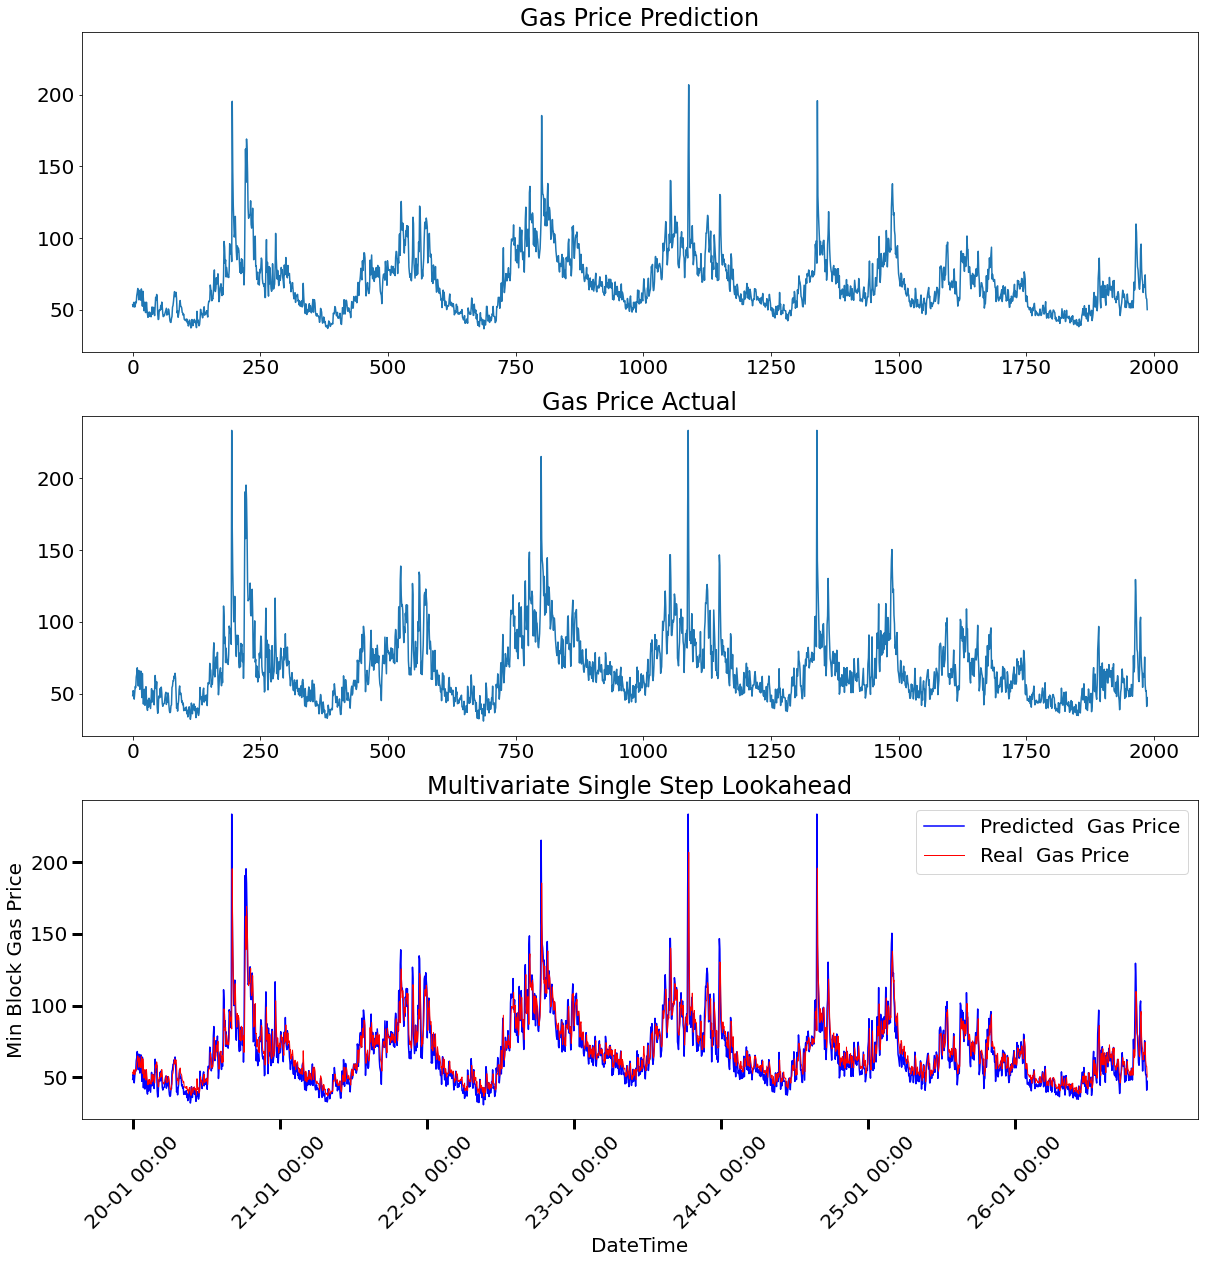

In [29]:
#Minmax scaler has been fit with nd data, 
pred_descaled= (scaler2.inverse_transform(array([yhat,]*len(inputs)).transpose()[0]))[ :, :1]
groud_truth_descaled= (scaler2.inverse_transform(array([y_val2,]*len(inputs)).transpose()[0][0]))[ :, :1]


f, (ax1, ax2, ax3) = plt.subplots(3, 1, sharey=True)
f.set_figwidth(20)
f.set_figheight(20)
ax1.plot(pred_descaled)
ax1.title.set_text('Gas Price Prediction')
ax2.plot(groud_truth_descaled)
ax2.title.set_text('Gas Price Actual')


ax3.set_xticks(np.arange(0, 1985, 288, dtype=None))
ax3.set_xticklabels(data['datetime'].tail(7).values.tolist(), rotation = 45)
ax3.tick_params(length=10, width=3)
ax3.title.set_text('Multivariate Single Step Lookahead')
ax3.plot(groud_truth_descaled, color='blue',label='Predicted '+' Gas Price')
ax3.plot(pred_descaled, color='red',label='Real '+' Gas Price', linewidth=1)
ax3.legend(loc='upper right')
ax3.set_xlabel('DateTime')
ax3.set_ylabel('Min Block Gas Price')



print('RMSE ' + str(mean_squared_error(groud_truth_descaled, pred_descaled, squared=False)))
print('MAE ' + str(mean_absolute_error(groud_truth_descaled, pred_descaled)))
print('MAPE ' + str(mean_absolute_percentage_error(groud_truth_descaled, pred_descaled)))
print('R^2 ' + str(r2_score(groud_truth_descaled, pred_descaled)))

In [199]:
pred_descaled= (scaler.inverse_transform(array([yhat,]*len(inputs)).transpose()[0]))

In [30]:
max(groud_truth_descaled)

array([233.36951617])